# Отток клиентов в компании «Ниединогоразрыва.ком»

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

# План

1. Изучить данные в файлах
2. Подготовить данные
3. Провести исследовательский анализ данных
4. Подготовка данных для обучения моделей, обучение моделей и подбор их гиперпараметров
5. Финальный отчёт

## Изучение данных

In [4]:
!pip install phik
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 10.0 MB/s eta 0:00:00


In [5]:
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import pandas as pd
import phik
from phik.report import plot_correlation_matrix
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, auc, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler

In [6]:
try:
    df_contract = pd.read_csv('/datasets/contract_new.csv')
    df_personal = pd.read_csv('/datasets/personal_new.csv')
    df_internet = pd.read_csv('/datasets/internet_new.csv')
    df_phone = pd.read_csv('/datasets/phone_new.csv')
except:
    df_contract = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv')
    df_personal = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv')
    df_internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv')
    df_phone = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv')

In [7]:
def analyze_df(df):
    display(df.head(5))
    display(df.describe())
    df.info()

In [8]:
analyze_df(df_contract)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [9]:
analyze_df(df_personal)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [10]:
analyze_df(df_internet)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [11]:
analyze_df(df_phone)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [12]:
df_internet['UseInternet'] = 1
df_phone['UsePhone'] = 1

Ввожу новые признаки, чтобы в дальнейшем можно было понять какими услугами пользуется клиент в соединённом датафрейме.

Объединим таблицы.

In [13]:
df1 = pd.merge(df_contract, df_personal, on='customerID', how='left')
df2 = pd.merge(df_internet, df_phone, on='customerID', how='left')
df = pd.merge(df1, df2, on='customerID', how='left')

In [14]:
analyze_df(df)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,UseInternet,MultipleLines,UsePhone
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,DSL,No,Yes,No,No,No,No,1.0,NaN,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,...,DSL,Yes,No,Yes,No,No,No,1.0,No,1.0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,DSL,Yes,Yes,No,No,No,No,1.0,No,1.0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,...,DSL,Yes,No,Yes,Yes,No,No,1.0,NaN,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,...,Fiber optic,No,No,No,No,No,No,1.0,No,1.0


,MonthlyCharges,SeniorCitizen,UseInternet,UsePhone
count,7043.000000,7043.000000,5517.0,4835.0
mean,64.761692,0.162147,1.0,1.0
std,30.090047,0.368612,0.0,0.0
min,18.250000,0.000000,1.0,1.0
25%,35.500000,0.000000,1.0,1.0
50%,70.350000,0.000000,1.0,1.0
75%,89.850000,0.000000,1.0,1.0
max,118.750000,1.000000,1.0,1.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


## Подготовка данных

Все столбцы приведём к одному формату записи.

In [15]:
df = df.rename(columns={'customerID':'CustomerID', 'gender':'Gender'})
display(df.columns)

Index(['CustomerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Gender',
       'SeniorCitizen', 'Partner', 'Dependents', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'UseInternet', 'MultipleLines',
       'UsePhone'],
      dtype='object')

Выделим целевой признак, коим является EndDate в отдельную перемунную refusal, где 0 означает, что клент не ушёл, а 1, что ушёл.

In [16]:
df.loc[df['EndDate'] == 'No', 'Refusal'] = 0
df.loc[df['EndDate'] != 'No', 'Refusal'] = 1

In [17]:
df['Refusal'] = df['Refusal'].astype('int')

Изменю значение 'No' на значение 2020-02-01 (дата выгрузки датафрейма).

In [18]:
df.loc[df['EndDate'] == 'No', 'EndDate'] = '2020-02-01'

Приведём к нужным типам данных.

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CustomerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   Gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


In [20]:
df[['BeginDate', 'EndDate']] = df[['BeginDate', 'EndDate']].apply(pd.to_datetime)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors ='coerce')
df['UseInternet'] = pd.to_numeric(df['UseInternet'], errors ='coerce')
df['UsePhone'] = pd.to_numeric(df['UsePhone'], errors ='coerce')

Создам новый столбец 'Period', который покажет сколько пользователь пользовался услугами.

In [21]:
df['Period'] = (df['EndDate'] - df['BeginDate']).dt.days

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   Gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14  OnlineBackup      5517 n

Рассмотрим пропуски.

In [23]:
df.isnull().sum()

CustomerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
Gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
UseInternet         1526
MultipleLines       2208
UsePhone            2208
Refusal                0
Period                 0
dtype: int64

In [24]:
df[df['TotalCharges'].isnull()]

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Gender,SeniorCitizen,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,UseInternet,MultipleLines,UsePhone,Refusal,Period
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,Female,0,...,No,Yes,Yes,Yes,No,1.0,NaN,NaN,0,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,Male,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,Female,0,...,Yes,Yes,No,Yes,Yes,1.0,No,1.0,0,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,Male,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,Female,0,...,Yes,Yes,Yes,Yes,No,1.0,NaN,NaN,0,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,Male,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,Male,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,Female,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,Male,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN,Female,0,...,Yes,Yes,Yes,Yes,No,1.0,Yes,1.0,0,0


Полагаю, что пропуски в столбцах 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines' обозначают отсутствие данной услуги. Заменю на 'No'. А пропуски в столбце 'TotalCharges' обусловлены тем, что клиенты пользуются услугами компании всего один день. Заменю на 0. Пропуски же в столбцах 'Use_Internet', 'Use_Phone' заменю 0, так как отсутствие означает, что клиент не использует.

In [25]:
for column in ('InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
               'StreamingTV', 'StreamingMovies', 'MultipleLines'):
    df[column] = df[column].fillna('No')

In [26]:
df['TotalCharges'] = df['TotalCharges'].fillna(0)

In [27]:
df['UsePhone'] = df['UsePhone'].fillna(0)
df['UseInternet'] = df['UseInternet'].fillna(0)

In [28]:
df.isna().sum()

CustomerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
UseInternet         0
MultipleLines       0
UsePhone            0
Refusal             0
Period              0
dtype: int64

Рассмотрим дубликаты.

In [29]:
df.duplicated().sum()

0

Дубликатов обнаружено не было.

## Исследовательский анализ данных

Рассмотрим дисбаланс классов.

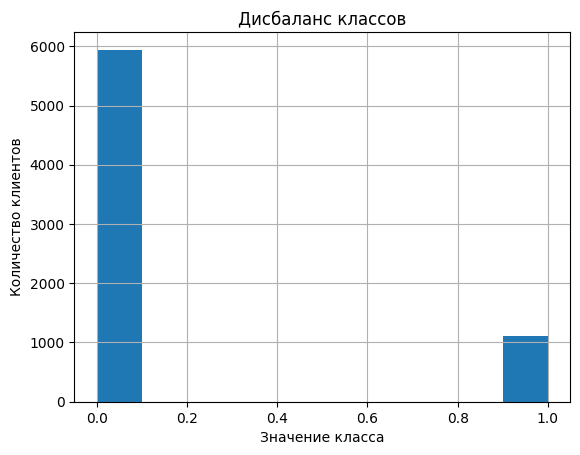

In [30]:
df['Refusal'].hist()
plt.ylabel('Количество клиентов')
plt.xlabel('Значение класса')
plt.title('Дисбаланс классов');

Клиентов, что всё ещё остались, гораздо больше, чем тех, кто ушёл.

 Рассмотрим распределение ежемесячных трат на услуги.

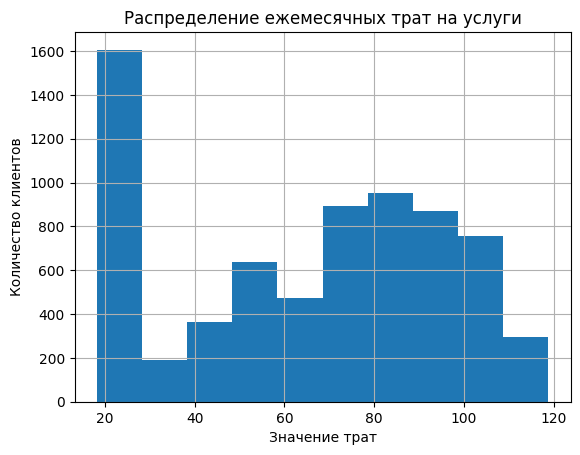

In [31]:
df['MonthlyCharges'].hist()
plt.ylabel('Количество клиентов')
plt.xlabel('Значение трат')
plt.title('Распределение ежемесячных трат на услуги');

Самое большое количество клиентов платит 30 платёжных единиц.

Рассмотрим ежемесячные платежи между ушедшими и оставшимися пользователями.

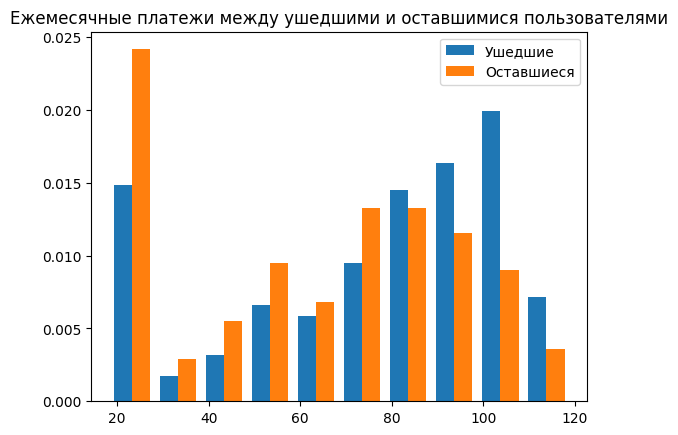

In [32]:
plt.hist([df[df.Refusal == 1].MonthlyCharges, df[df.Refusal == 0].MonthlyCharges], label=['Ушедшие', 'Оставшиеся'], density=True)
plt.legend()
plt.title('Ежемесячные платежи между ушедшими и оставшимися пользователями');

Видно, что оставшиеся клиенты чаще используют маленькие ежемесячные платежи, тогда как у ушедших имеется высокая плотность на высоких ежемесячных платежах.

Рассмотрим распределение услуг между интернетом и телефоном.

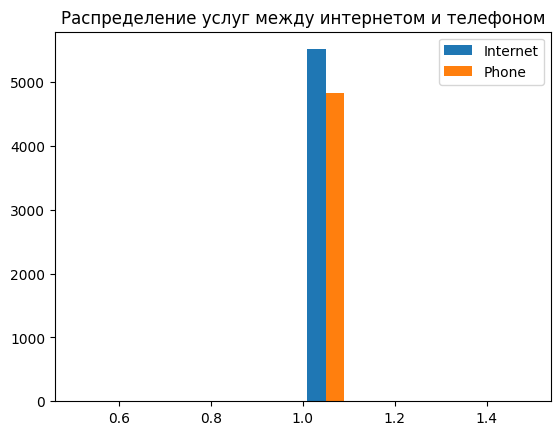

In [33]:
plt.hist([df[df.UseInternet == 1].UseInternet, df[df.UsePhone == 1].UsePhone], label=['Internet', 'Phone'])
plt.legend()
plt.title('Распределение услуг между интернетом и телефоном')
plt.show();

Распределение показывает, что пользователей интернета немногим больше. Но в целом распределние почти равное.

Уберём ненужные признаки перед построением корреляции.

In [34]:
del df['CustomerID'], df['BeginDate'], df['EndDate']

Проверка корреляций при помощи библиотеки phik.

In [35]:
interval_cols = df[['MonthlyCharges', 'TotalCharges', 'Period']]

In [36]:
phik_overview = df.phik_matrix(interval_cols=interval_cols)
phik_overview

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Gender,SeniorCitizen,Partner,Dependents,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,UseInternet,MultipleLines,UsePhone,Refusal,Period
Type,1.000000,0.106860,0.277462,0.388444,0.470860,0.000000,0.086231,0.179736,0.147680,0.505187,...,0.098884,0.137610,0.179999,0.066961,0.069608,0.146647,0.000000,0.129045,0.094015,0.634155
PaperlessBilling,0.106860,1.000000,0.370495,0.467812,0.201703,0.000000,0.242133,0.013218,0.172593,0.231438,...,0.196443,0.160796,0.055929,0.343524,0.325551,0.482393,0.331437,0.447069,0.083398,0.026799
PaymentMethod,0.277462,0.370495,1.000000,0.399526,0.335666,0.000000,0.292725,0.243008,0.224903,0.323886,...,0.282475,0.306866,0.272101,0.377209,0.378907,0.535120,0.383474,0.482452,0.214832,0.350964
MonthlyCharges,0.388444,0.467812,0.399526,1.000000,0.710905,0.008175,0.304985,0.203545,0.184366,0.919002,...,0.629541,0.667481,0.576525,0.835340,0.833307,0.998690,0.806232,0.988863,0.226280,0.387727
TotalCharges,0.470860,0.201703,0.335666,0.710905,1.000000,0.000000,0.135650,0.381958,0.084247,0.490081,...,0.622445,0.640977,0.550065,0.641488,0.643210,0.548907,0.642986,0.550639,0.302890,0.848337
Gender,0.000000,0.000000,0.000000,0.008175,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.009882,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008581,0.000000
SeniorCitizen,0.086231,0.242133,0.292725,0.304985,0.135650,0.000000,1.000000,0.016992,0.324576,0.160702,...,0.102065,0.090686,0.092565,0.163120,0.186141,0.281853,0.269018,0.259204,0.086159,0.063315
Partner,0.179736,0.013218,0.243008,0.203545,0.381958,0.000000,0.016992,1.000000,0.652122,0.000000,...,0.219223,0.238079,0.185993,0.193258,0.182011,0.000000,0.173095,0.000000,0.226688,0.453688
Dependents,0.147680,0.172593,0.224903,0.184366,0.084247,0.000000,0.324576,0.652122,1.000000,0.108463,...,0.031533,0.010416,0.096912,0.017331,0.058999,0.216514,0.101930,0.194146,0.046871,0.198729
InternetService,0.505187,0.231438,0.323886,0.919002,0.490081,0.000000,0.160702,0.000000,0.108463,1.000000,...,0.233602,0.232916,0.239663,0.272818,0.272782,1.000000,0.317052,0.554191,0.056621,0.060845


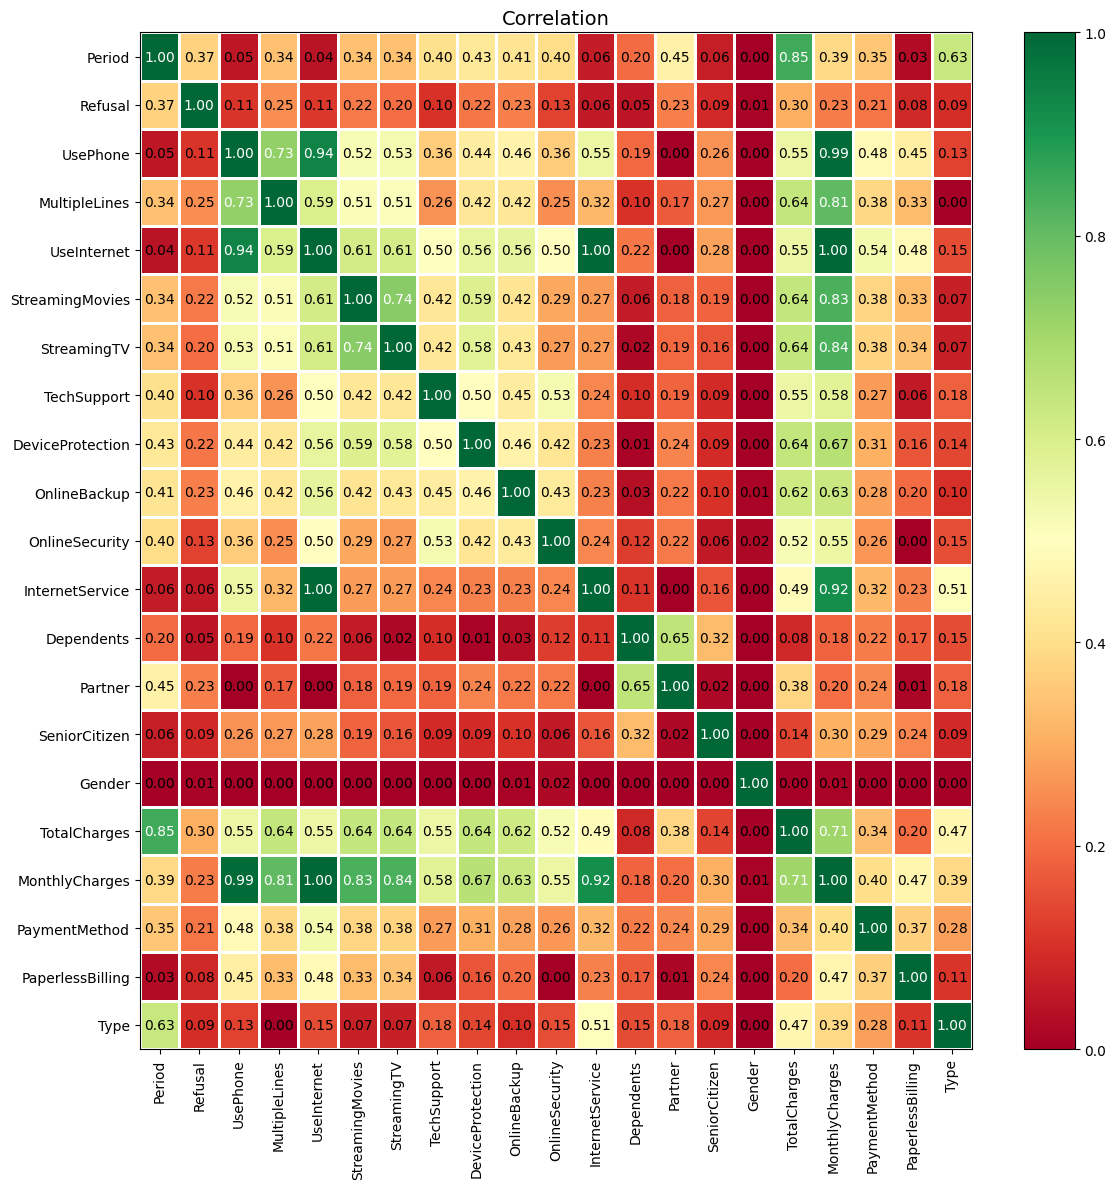

In [37]:
plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1,
                        title='Correlation', figsize=(12, 12))

Очень низкая корреляция с признаками 'Gender', 'Type', 'PaperlessBilling', 'SeniorCitizen', 'Dependents', 'InternetService'. Предлагаю исключить их для обучения моделей.

In [38]:
del df['Gender'], df['Type'], df['PaperlessBilling'], df['SeniorCitizen'], df['Dependents'], df['InternetService']

## Подготовка данных для обучения моделей, обучение моделей и подбор их гиперпараметров

In [39]:
RANDOM_STATE = 28082023

Деление на выборки

In [40]:
features = df.drop(['Refusal'], axis=1)
target = df['Refusal']
features_train, features_test, target_train, target_test = \
                                                            train_test_split(features, target, \
                                                            test_size=0.25, random_state=RANDOM_STATE)
display(features_train.shape)
display(target_train.shape)
display(features_test.shape)
display(target_test.shape)

(5282, 14)

(5282,)

(1761, 14)

(1761,)

Прямое кодирование

In [41]:
features_train_ohe = pd.get_dummies(features_train, drop_first=True)
features_test_ohe = pd.get_dummies(features_test, drop_first=True)

In [42]:
display(features_train_ohe.head())
display(features_test_ohe.head())

,MonthlyCharges,TotalCharges,UseInternet,UsePhone,Period,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Partner_Yes,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
6563,74.90,1198.40,1.0,1.0,488,0,0,0,1,0,0,0,0,0,0,1
3998,54.50,114.45,1.0,1.0,61,0,0,1,1,1,1,0,0,0,0,0
5434,95.30,3459.39,1.0,1.0,1006,0,0,0,0,1,0,1,0,0,1,1
2107,93.35,3080.55,1.0,1.0,1006,0,1,0,1,0,1,1,0,0,1,1
2569,24.85,1789.20,0.0,0.0,2191,1,0,0,1,0,0,0,0,0,0,0


,MonthlyCharges,TotalCharges,UseInternet,UsePhone,Period,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Partner_Yes,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
6548,54.35,1718.55,1.0,1.0,945,0,0,1,1,0,0,1,1,0,0,0
2030,60.95,121.90,1.0,1.0,62,0,0,0,0,1,1,0,0,0,0,1
708,75.30,2205.54,1.0,1.0,883,1,0,0,1,0,0,1,0,0,0,0
1979,20.00,706.20,0.0,0.0,1006,0,0,0,1,0,0,0,0,0,0,0
4745,100.45,2511.25,1.0,1.0,760,0,1,0,1,0,0,1,0,1,1,1


In [43]:
(features_train_ohe.columns == features_test_ohe.columns).all()

True

Имена столбцов, порядок их следования и количество в закодированных выборках совпадают.

Стандартизация данных

In [44]:
numeric = ['MonthlyCharges', 'TotalCharges', 'Period']
scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train_scaled = scaler.transform(features_train[numeric])
features_test_scaled = scaler.transform(features_test[numeric])

scaler_ohe = StandardScaler()
scaler_ohe.fit(features_train_ohe[numeric])

features_train_ohe_scaled = scaler.transform(features_train_ohe[numeric])
features_test_ohe_scaled = scaler.transform(features_test_ohe[numeric])

Логистическая регрессия

In [45]:
%%time

lr = LogisticRegression(random_state=RANDOM_STATE)

parametrs = {'C': range (1, 10),
              'max_iter': range (100, 1001, 50)}

rs = RandomizedSearchCV(lr, parametrs, random_state=RANDOM_STATE, scoring='roc_auc')
rs.fit(features_train_ohe_scaled, target_train)
probabilities_lr = rs.best_estimator_.predict_proba(features_test_ohe_scaled)[:, 1]
lr_roc_auc = rs.best_score_
lr_test = roc_auc_score(target_test, probabilities_lr)
print('roc_auc', lr_roc_auc)
print('roc_auc test', lr_test)

roc_auc 0.6480165493209766
roc_auc test 0.6530899820331647
CPU times: user 457 ms, sys: 315 ms, total: 772 ms
Wall time: 415 ms


Случайный лес

In [46]:
%%time

rfc = RandomForestClassifier(random_state=RANDOM_STATE)

parametrs = {'n_estimators': range(1, 1001, 50),
             'criterion': ['gini', 'entropy'],
             'max_depth': range(1, 51),
             'min_samples_leaf': range(1,11)}

rs = RandomizedSearchCV(rfc, parametrs, random_state=RANDOM_STATE, scoring='roc_auc')
rs.fit(features_train_ohe_scaled, target_train)
probabilities_rfc = rs.best_estimator_.predict_proba(features_test_ohe_scaled)[:, 1]
rfc_roc_auc = rs.best_score_
rfc_test = roc_auc_score(target_test, probabilities_rfc)
print('roc_auc', rfc_roc_auc)
print('roc_auc test', rfc_test)

roc_auc 0.7935806692860161
roc_auc test 0.8096893216063515
CPU times: user 1min 41s, sys: 269 ms, total: 1min 41s
Wall time: 1min 42s


CatBoost

In [47]:
display(features_train.info())
display(features_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5282 entries, 6563 to 727
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PaymentMethod     5282 non-null   object 
 1   MonthlyCharges    5282 non-null   float64
 2   TotalCharges      5282 non-null   float64
 3   Partner           5282 non-null   object 
 4   OnlineSecurity    5282 non-null   object 
 5   OnlineBackup      5282 non-null   object 
 6   DeviceProtection  5282 non-null   object 
 7   TechSupport       5282 non-null   object 
 8   StreamingTV       5282 non-null   object 
 9   StreamingMovies   5282 non-null   object 
 10  UseInternet       5282 non-null   float64
 11  MultipleLines     5282 non-null   object 
 12  UsePhone          5282 non-null   float64
 13  Period            5282 non-null   int64  
dtypes: float64(4), int64(1), object(9)
memory usage: 619.0+ KB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1761 entries, 6548 to 6668
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PaymentMethod     1761 non-null   object 
 1   MonthlyCharges    1761 non-null   float64
 2   TotalCharges      1761 non-null   float64
 3   Partner           1761 non-null   object 
 4   OnlineSecurity    1761 non-null   object 
 5   OnlineBackup      1761 non-null   object 
 6   DeviceProtection  1761 non-null   object 
 7   TechSupport       1761 non-null   object 
 8   StreamingTV       1761 non-null   object 
 9   StreamingMovies   1761 non-null   object 
 10  UseInternet       1761 non-null   float64
 11  MultipleLines     1761 non-null   object 
 12  UsePhone          1761 non-null   float64
 13  Period            1761 non-null   int64  
dtypes: float64(4), int64(1), object(9)
memory usage: 206.4+ KB


None

Изменим тип данных категориальных признаков в столбцах 'UseInternet', 'UsePhone' с вещественных чисел на целые, чтобы можно было работать с ними в CatBoost.

In [48]:
pd.options.mode.chained_assignment = None
features_train[['UseInternet', 'UsePhone']] = features_train[['UseInternet', 'UsePhone']].astype('int')
features_test[['UseInternet', 'UsePhone']] = features_test[['UseInternet', 'UsePhone']].astype('int')

In [49]:
display(features_train.info())
display(features_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5282 entries, 6563 to 727
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PaymentMethod     5282 non-null   object 
 1   MonthlyCharges    5282 non-null   float64
 2   TotalCharges      5282 non-null   float64
 3   Partner           5282 non-null   object 
 4   OnlineSecurity    5282 non-null   object 
 5   OnlineBackup      5282 non-null   object 
 6   DeviceProtection  5282 non-null   object 
 7   TechSupport       5282 non-null   object 
 8   StreamingTV       5282 non-null   object 
 9   StreamingMovies   5282 non-null   object 
 10  UseInternet       5282 non-null   int64  
 11  MultipleLines     5282 non-null   object 
 12  UsePhone          5282 non-null   int64  
 13  Period            5282 non-null   int64  
dtypes: float64(2), int64(3), object(9)
memory usage: 619.0+ KB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1761 entries, 6548 to 6668
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PaymentMethod     1761 non-null   object 
 1   MonthlyCharges    1761 non-null   float64
 2   TotalCharges      1761 non-null   float64
 3   Partner           1761 non-null   object 
 4   OnlineSecurity    1761 non-null   object 
 5   OnlineBackup      1761 non-null   object 
 6   DeviceProtection  1761 non-null   object 
 7   TechSupport       1761 non-null   object 
 8   StreamingTV       1761 non-null   object 
 9   StreamingMovies   1761 non-null   object 
 10  UseInternet       1761 non-null   int64  
 11  MultipleLines     1761 non-null   object 
 12  UsePhone          1761 non-null   int64  
 13  Period            1761 non-null   int64  
dtypes: float64(2), int64(3), object(9)
memory usage: 206.4+ KB


None

In [50]:
%%time

cat_features = ['PaymentMethod', 'Partner', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport', 'StreamingTV', 'StreamingMovies', 'UseInternet', 'UsePhone', 'MultipleLines']
cb = CatBoostClassifier(random_state=RANDOM_STATE)

parametrs = {'learning_rate': [0.1, 0.3],
             'iterations': [100, 1500],
             'l2_leaf_reg': [1, 9]}

rs = RandomizedSearchCV(cb, parametrs, random_state=RANDOM_STATE, scoring='roc_auc')
rs.fit(features_train, target_train, cat_features=cat_features, verbose=100)
probabilities_cb = rs.best_estimator_.predict_proba(features_test)[:, 1]
cb_roc_auc = rs.best_score_
cb_test = roc_auc_score(target_test, probabilities_cb)
print('roc_auc', cb_roc_auc)
print('roc_auc test', cb_test)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0:	learn: 0.6428983	total: 49.1ms	remaining: 4.86s
99:	learn: 0.3019741	total: 217ms	remaining: 0us
0:	learn: 0.6427362	total: 2.27ms	remaining: 225ms
99:	learn: 0.2948479	total: 164ms	remaining: 0us
0:	learn: 0.6420528	total: 2.39ms	remaining: 237ms
99:	learn: 0.3003271	total: 184ms	remaining: 0us
0:	learn: 0.6417651	total: 1.89ms	remaining: 187ms
99:	learn: 0.3009203	total: 177ms	remaining: 0us
0:	learn: 0.6416641	total: 2ms	remaining: 198ms
99:	learn: 0.2979854	total: 169ms	remaining: 0us
0:	learn: 0.5574902	total: 1.94ms	remaining: 192ms
99:	learn: 0.2222899	total: 178ms	remaining: 0us
0:	learn: 0.5570423	total: 1.94ms	remaining: 192ms
99:	learn: 0.2197651	total: 183ms	remaining: 0us
0:	learn: 0.5554508	total: 1.87ms	remaining: 185ms
99:	learn: 0.2153685	total: 178ms	remaining: 0us
0:	learn: 0.5546631	total: 3.13ms	remaining: 310ms
99:	learn: 0.2203571	total: 177ms	remaining: 0us
0:	learn: 0.5543714	total: 1.81ms	remaining: 179ms
99:	learn: 0.2255122	total: 180ms	remaining: 0us
0:	

Лучшее значение по метрике получилось у CatBoost. Его и будем использовать.

Тест модели

In [51]:
cb_best = rs.best_params_
display(cb_best)

{'learning_rate': 0.1, 'l2_leaf_reg': 9, 'iterations': 1500}

In [52]:
cb_test = roc_auc_score(target_test, probabilities_cb)
print('roc_auc test', cb_test)

roc_auc test 0.923481892028729


Был пройден назначенный заказчиком порог в 0.85. Метрика на тестововой выборке выше, чем на тренировочной, потому что модель, вероятно, переобучена. Посоветую добавлять новые данные для будущего до обучения модели.

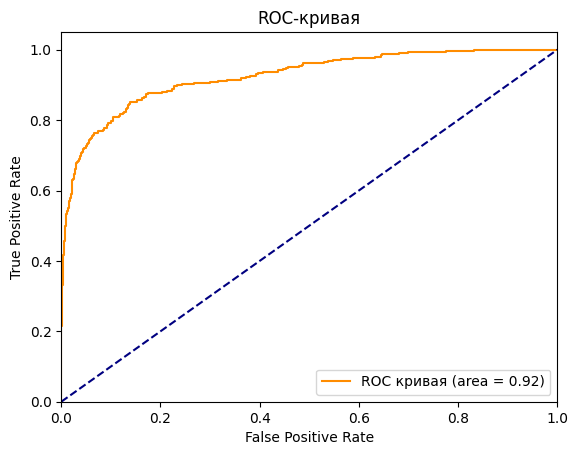

ROC_AUC Метрика 0.923481892028729


In [53]:
fpr, tpr, treshold = roc_curve(target_test, probabilities_cb)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()
print('ROC_AUC Метрика', cb_test)

Синяя пунктирная линия в данном случае — случайная модель. Т. е. её ROC_AUC метрика равна 0.5 и она угадывает как положительные, так и отрицателные классы с вероятностью 50%. У нашей же модели данный показатель равен 0.92 или 92%. Также можно увидеть, что площать под нашей кривой гораздо больше, что также доказывает большую эффективность нашей модели.

In [54]:
predictions = rs.best_estimator_.predict(features_test)

In [55]:
print('Accuracy Метрика ', accuracy_score(target_test, predictions))

Accuracy Метрика  0.9119818285065304


На тестовой выборке наша модель показывает отличный результат, удовлетворяющий заказчика.

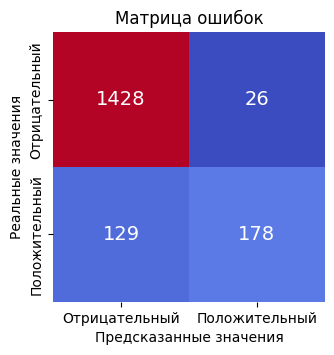

In [56]:
cm = confusion_matrix(target_test, predictions)

plt.figure(figsize=(3.5, 3.5))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", cbar=False,
            annot_kws={"size": 14},
            xticklabels=["Отрицательный", "Положительный"],
            yticklabels=["Отрицательный", "Положительный"])
plt.xlabel("Предсказанные значения")
plt.ylabel("Реальные значения")
plt.title("Матрица ошибок")
plt.show()

Модель предсказала правильно 1428 оставшихся клиентов и 178 ушедших. Допустила 129 ошибок первого рода, что означает, модель предсказала, что клиент останется, но на самом деле он ушёл. И допустила 26 ошибок второго рода,что означает, модель предсказала, что клиент уйдёт, а клиент остался.

Важность признаков

In [57]:
importance = pd.DataFrame(rs.best_estimator_.feature_importances_, index = features_test.columns, columns=['importance'])
importance = importance.sort_values(by='importance', ascending=False)
display(importance)

,importance
Period,45.357030
TotalCharges,12.814250
MonthlyCharges,12.618143
PaymentMethod,7.977024
Partner,5.150609
MultipleLines,2.889234
OnlineBackup,2.277668
OnlineSecurity,2.255987
DeviceProtection,1.907046
TechSupport,1.814714


Самыми важными оказались признаки: период, который показывает, сколько пользователь пользуется услугами компании; сколько всего потрачено денег на услуги; ежемесячные траты на услуги.

## Финальный отчёт

Мною была проделана большая работа: все пункты плана были выполнены.
Возникли трудности с прямым кодированием, так как не знал, что именно прямое (не порядковое) кодирование подходит для линейных моеделей. Исправил досточно просто, поменяв порядковое на прямое кодирование.
    
1. Были изучены данные; введены новые признаки UseInternet и UsePhone, чтобы в дальнейшем можно было понять какими услугами пользуется клиент в объединённом датафрейме. Объединены датафреймы.
    
2. Данные были подготовлены: все столбцы приведены к единому формату; был выделен целевой признак под названием Refusal. Для того, чтобы выделить новый признак Period, который будет показыввать длительность пользования услугами компании клиентом, значение 'No' бы заменено на дату выгрузки датафрейма. Все данные приведены к нужному типу. Были заполнены пропуски и обработаны дубликаты.
    
3. Проведён исседовательский анализ данных: рассмотрен дисбаланс классов, распределение ежемесячных трат на услуги, ежемесячные платежи между ушедшими и оставшимися клиентами, распределение услуг между интернетом и телефоном.Построена матрица корреляций и удалены из датафрейма столбцы с низкой корреляцией.

4. Произведена подготовка данных для обучения моделей, обучение моделей и подбор их гиперпараметров: было проделано деление на выборки, прямое кодирование, стандартизация данных. Для обучения были выбраны 3 модели: логистическая регрессия, случайный лес и CatBoost. Лучшее значение метрики получились у CatBoost, имеющего гиперпараметры 'learning_rate' = 0.1, 'l2_leaf_reg' = 9, iiterations' = 1500, со значением 0.898019 на тренировочной выборке и значением 0.923482 на тестовой. Как уже отмечалось ранее, значение на тестовой выборке выше, чем значение на тренировочной выборке, потому что, скорее всего, модель переобучена. Это можно было бы исправить путём использование более информативных признаков, обучение модели в конвейере и подбор более эффктивных гиперпараметров.Построена ROC-кривая, матрица ошибок и построен Series важности признаков.